In [31]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=""

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=""


In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = ""

In [2]:
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
from pyro.nn import PyroModule, PyroParam, PyroSample
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO, MCMC, Predictive
from pyro.infer.mcmc import NUTS
import pyro.poutine as poutine

from modules.config import read_config
from modules.datageneration import load_data, data_functions
from src.pipeline_util import load_bnn

from src import generate, train, eval
import os
import pickle

from torch.utils.data import random_split, TensorDataset
from torch.utils.data.dataloader import DataLoader
from modules.bnn_model import BayesianNN, NormalPrior, GaussianLikelihood
from modules.mcmc_bnn import MCMC_BNN

/Home/siv31/tak011/.conda/envs/master/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
BASE_DIR = "../tests/sanity_check"
PROFILE = "tyxe-test"

In [4]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

In [5]:
config["DEVICE"] = "cuda:7"#config["DEVICE"]

config["MCMC_NUM_SAMPLES"] = "50"
config["MCMC_NUM_WARMUP"] = "20"
config["MCMC_NUM_CHAINS"] = "2"
config["RERUNS"] = "1"

config["HIDDEN_FEATURES"] = "[32]"
config["LIKELIHOOD_SCALE"] = "0.3"

dataset_config["TRAIN_SIZE"] = "100"
dataset_config["TEST_SIZE"] = "100"
dataset_config["SIGMA"] = "0.3"

In [6]:
[torch.cuda.device(i) for i in range(torch.cuda.device_count())]

====== Generating profile sin-(10,20)-10k ======
Train: (-10, 10)
Y-space: -1.4279431423488806 - 1.5602615588548145
In Domain: (-10, 10)
Y-space: -1.5728629001484995 - 1.5151104079718951
Out Domain: (-20, 20)
Y-space: -1.5110794057988066 - 1.4468968173085783


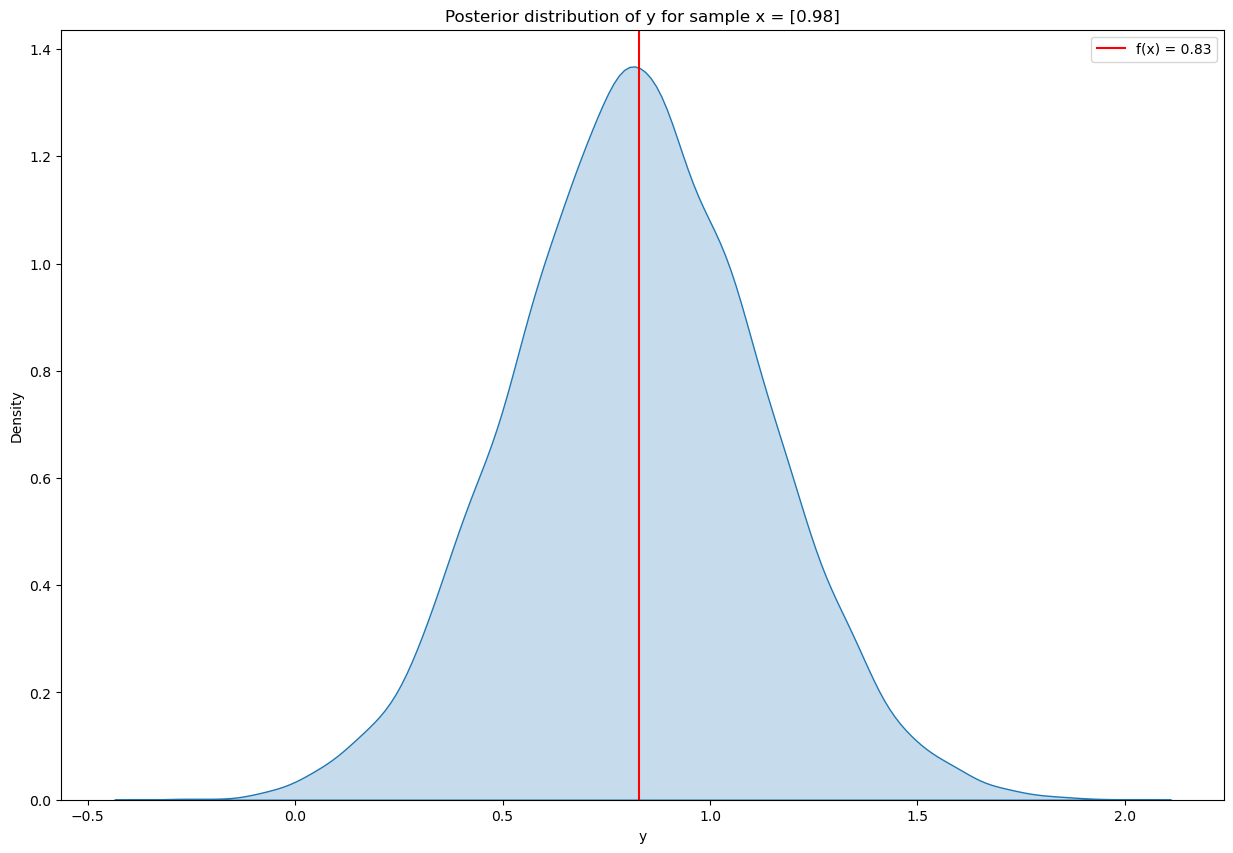

In [7]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [8]:
(x_train, y_train), _, (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)
x_test, y_test = torch.vstack((x_test_in_domain, x_test_out_domain)), torch.vstack((y_test_in_domain, y_test_out_domain))

In [9]:
x_train.shape, y_train.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

In [10]:
train_dataset = TensorDataset(x_train, y_train)

train_dataloader = DataLoader(train_dataset, batch_size=128)

In [11]:
x, y = next(iter(train_dataloader))

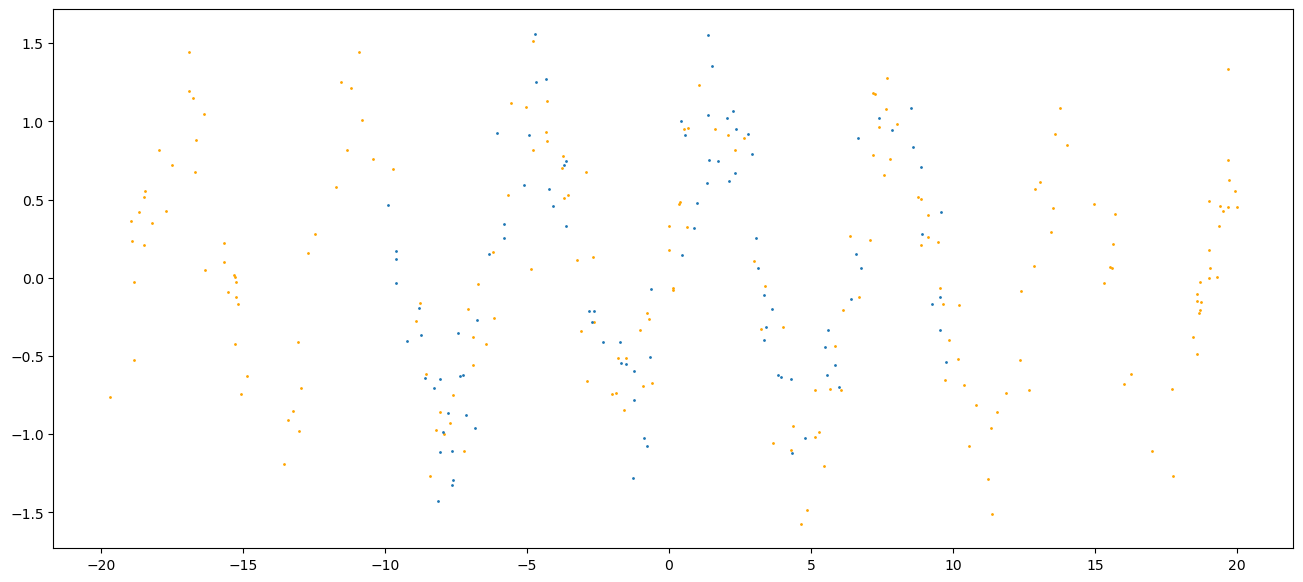

In [12]:

test_sort = torch.argsort(x_test.squeeze())
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="orange", s=1)
plt.scatter(x_train.squeeze(), y_train, s=1)

In [13]:
prior = NormalPrior(torch.tensor(0, device=config["DEVICE"]), torch.tensor(1, device=config["DEVICE"]))
likelihood = GaussianLikelihood(dist.Gamma(torch.tensor(1.0, device=config["DEVICE"]), torch.tensor(1.0, device=config["DEVICE"])), len(x_train), device=config["DEVICE"])
model = BayesianNN(1, 1, prior, hidden_features=[32], device=config["DEVICE"])
model

BayesianNN(
  (fc0): BayesianLayer(
    (linear): PyroLinear(in_features=1, out_features=32, bias=True)
  )
  (act0): ReLU()
  (fc1): BayesianLayer(
    (linear): PyroLinear(in_features=32, out_features=1, bias=True)
  )
)

In [14]:
kernel_builder = NUTS
mcmc_bnn = MCMC_BNN(model, likelihood, kernel_builder, device=config["DEVICE"])

In [17]:
with open(f"{BASE_DIR}/results/{NAME}/test.pkl", "wb") as f:
        pickle.dump(mcmc_bnn._mcmc, f)

In [16]:
mcmc_bnn.fit(train_dataloader, num_samples=50, num_warmup=20, num_chains=2, mp_context="spawn", device=config["DEVICE"])

Warmup [2]:   0%|          | 0/70 [00:00, ?it/s]


TypeError: cannot pickle '_thread.lock' object

In [18]:
with poutine.trace() as tr:
    #mcmc_bnn._model(x_test)
    mcmc_bnn.likelihood.get_scale()
tr.trace.nodes.keys()

odict_keys(['likelihood._scale'])

In [19]:
mcmc_bnn._mcmc.get_samples()["likelihood._scale"]

tensor([0.3759, 0.3759, 0.3759, 0.3759, 0.3756, 0.3756, 0.3756, 0.3756, 0.3756,
        0.3762, 0.3763, 0.3763, 0.3763, 0.3762, 0.3751, 0.3751, 0.3751, 0.3751,
        0.3751, 0.3756, 0.3756, 0.3756, 0.3756, 0.3756, 0.3734, 0.3734, 0.3734,
        0.3734, 0.3726, 0.3732, 0.3732, 0.3732, 0.3725, 0.3725, 0.3725, 0.3725,
        0.3725, 0.3725, 0.3732, 0.3732, 0.3729, 0.3727, 0.3727, 0.3737, 0.3737,
        0.3730, 0.3729, 0.3729, 0.3729, 0.3729, 0.3850, 0.3850, 0.3850, 0.3850,
        0.3850, 0.3850, 0.3850, 0.3850, 0.3850, 0.3850, 0.3850, 0.3850, 0.3850,
        0.3850, 0.3850, 0.3850, 0.3850, 0.3850, 0.3850, 0.3850, 0.3850, 0.3850,
        0.3850, 0.3850, 0.3850, 0.3850, 0.3850, 0.3850, 0.3850, 0.3850, 0.3850,
        0.3850, 0.3850, 0.3850, 0.3850, 0.3850, 0.3850, 0.3850, 0.3850, 0.3850,
        0.3850, 0.3850, 0.3850, 0.3850, 0.3850, 0.3850, 0.3850, 0.3850, 0.3850,
        0.3850])

In [20]:
tr.trace.nodes["likelihood._scale"]

{'type': 'sample',
 'name': 'likelihood._scale',
 'fn': Gamma(concentration: 1.0, rate: 1.0),
 'is_observed': False,
 'args': (),
 'kwargs': {},
 'value': tensor(1.2268),
 'infer': {},
 'scale': 1.0,
 'mask': None,
 'cond_indep_stack': (),
 'done': True,
 'stop': False,
 'continuation': None}

In [21]:
x_samps = x_test[:5]
preds = mcmc_bnn.predict(x_samps, num_predictions=100, aggregate=False)

tensor([0.3732, 0.3756, 0.3759, 0.3756, 0.3751, 0.3732, 0.3850, 0.3730, 0.3850,
        0.3850, 0.3850, 0.3729, 0.3762, 0.3850, 0.3759, 0.3850, 0.3751, 0.3850,
        0.3725, 0.3726, 0.3850, 0.3850, 0.3850, 0.3762, 0.3850, 0.3725, 0.3759,
        0.3756, 0.3850, 0.3850, 0.3850, 0.3751, 0.3850, 0.3732, 0.3850, 0.3850,
        0.3850, 0.3756, 0.3729, 0.3737, 0.3850, 0.3850, 0.3732, 0.3850, 0.3850,
        0.3756, 0.3850, 0.3850, 0.3850, 0.3850, 0.3850, 0.3763, 0.3756, 0.3751,
        0.3734, 0.3763, 0.3751, 0.3850, 0.3850, 0.3734, 0.3756, 0.3734, 0.3850,
        0.3850, 0.3751, 0.3850, 0.3734, 0.3850, 0.3725, 0.3850, 0.3850, 0.3850,
        0.3850, 0.3850, 0.3850, 0.3850, 0.3850, 0.3751, 0.3850, 0.3751, 0.3850,
        0.3732, 0.3727, 0.3850, 0.3734, 0.3756, 0.3732, 0.3850, 0.3850, 0.3732,
        0.3726, 0.3850, 0.3729, 0.3756, 0.3732, 0.3850, 0.3850, 0.3850, 0.3850,
        0.3732])
tensor([0.3732, 0.3756, 0.3759, 0.3756, 0.3751, 0.3732, 0.3850, 0.3730, 0.3850,
        0.3850, 0.3850,

In [22]:
preds.mean(dim=0)

tensor([[ 0.3671],
        [ 0.9985],
        [-0.4950],
        [ 0.6683],
        [ 0.9791]])

In [23]:
train_sort = torch.argsort(x_train.squeeze())
preds = mcmc_bnn.predict(x_train[train_sort], num_predictions=1000, aggregate=True)

# For homoskedastic aggregate True
means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

tensor([0.3756, 0.3725, 0.3850, 0.3759, 0.3850, 0.3759, 0.3756, 0.3850, 0.3850,
        0.3763, 0.3850, 0.3762, 0.3850, 0.3850, 0.3737, 0.3850, 0.3850, 0.3850,
        0.3763, 0.3850, 0.3759, 0.3759, 0.3850, 0.3850, 0.3730, 0.3850, 0.3850,
        0.3850, 0.3751, 0.3850, 0.3727, 0.3850, 0.3756, 0.3756, 0.3726, 0.3730,
        0.3756, 0.3850, 0.3850, 0.3850, 0.3850, 0.3850, 0.3762, 0.3850, 0.3756,
        0.3725, 0.3734, 0.3726, 0.3729, 0.3850, 0.3850, 0.3729, 0.3732, 0.3725,
        0.3756, 0.3850, 0.3756, 0.3850, 0.3756, 0.3850, 0.3850, 0.3850, 0.3756,
        0.3850, 0.3850, 0.3759, 0.3751, 0.3756, 0.3730, 0.3751, 0.3732, 0.3759,
        0.3850, 0.3732, 0.3850, 0.3850, 0.3850, 0.3759, 0.3751, 0.3759, 0.3850,
        0.3850, 0.3850, 0.3734, 0.3762, 0.3725, 0.3756, 0.3737, 0.3850, 0.3732,
        0.3850, 0.3729, 0.3756, 0.3850, 0.3751, 0.3850, 0.3756, 0.3850, 0.3729,
        0.3850, 0.3756, 0.3850, 0.3725, 0.3850, 0.3850, 0.3850, 0.3756, 0.3850,
        0.3850, 0.3756, 0.3756, 0.3850, 

tensor([0.3756, 0.3725, 0.3850, 0.3759, 0.3850, 0.3759, 0.3756, 0.3850, 0.3850,
        0.3763, 0.3850, 0.3762, 0.3850, 0.3850, 0.3737, 0.3850, 0.3850, 0.3850,
        0.3763, 0.3850, 0.3759, 0.3759, 0.3850, 0.3850, 0.3730, 0.3850, 0.3850,
        0.3850, 0.3751, 0.3850, 0.3727, 0.3850, 0.3756, 0.3756, 0.3726, 0.3730,
        0.3756, 0.3850, 0.3850, 0.3850, 0.3850, 0.3850, 0.3762, 0.3850, 0.3756,
        0.3725, 0.3734, 0.3726, 0.3729, 0.3850, 0.3850, 0.3729, 0.3732, 0.3725,
        0.3756, 0.3850, 0.3756, 0.3850, 0.3756, 0.3850, 0.3850, 0.3850, 0.3756,
        0.3850, 0.3850, 0.3759, 0.3751, 0.3756, 0.3730, 0.3751, 0.3732, 0.3759,
        0.3850, 0.3732, 0.3850, 0.3850, 0.3850, 0.3759, 0.3751, 0.3759, 0.3850,
        0.3850, 0.3850, 0.3734, 0.3762, 0.3725, 0.3756, 0.3737, 0.3850, 0.3732,
        0.3850, 0.3729, 0.3756, 0.3850, 0.3751, 0.3850, 0.3756, 0.3850, 0.3729,
        0.3850, 0.3756, 0.3850, 0.3725, 0.3850, 0.3850, 0.3850, 0.3756, 0.3850,
        0.3850, 0.3756, 0.3756, 0.3850, 

In [24]:
stds

tensor([[0.3828],
        [0.3825],
        [0.3825],
        [0.3825],
        [0.3822],
        [0.3821],
        [0.3820],
        [0.3820],
        [0.3820],
        [0.3820],
        [0.3820],
        [0.3820],
        [0.3820],
        [0.3821],
        [0.3819],
        [0.3817],
        [0.3817],
        [0.3907],
        [0.3921],
        [0.3880],
        [0.3857],
        [0.3849],
        [0.3856],
        [0.4019],
        [0.4200],
        [0.4398],
        [0.4400],
        [0.4205],
        [0.4156],
        [0.4171],
        [0.4166],
        [0.3872],
        [0.3851],
        [0.3879],
        [0.3898],
        [0.3901],
        [0.3902],
        [0.3973],
        [0.3983],
        [0.3995],
        [0.4028],
        [0.3910],
        [0.3909],
        [0.3879],
        [0.3844],
        [0.3843],
        [0.3842],
        [0.4033],
        [0.4305],
        [0.4653],
        [0.4831],
        [0.4326],
        [0.4243],
        [0.4243],
        [0.4125],
        [0

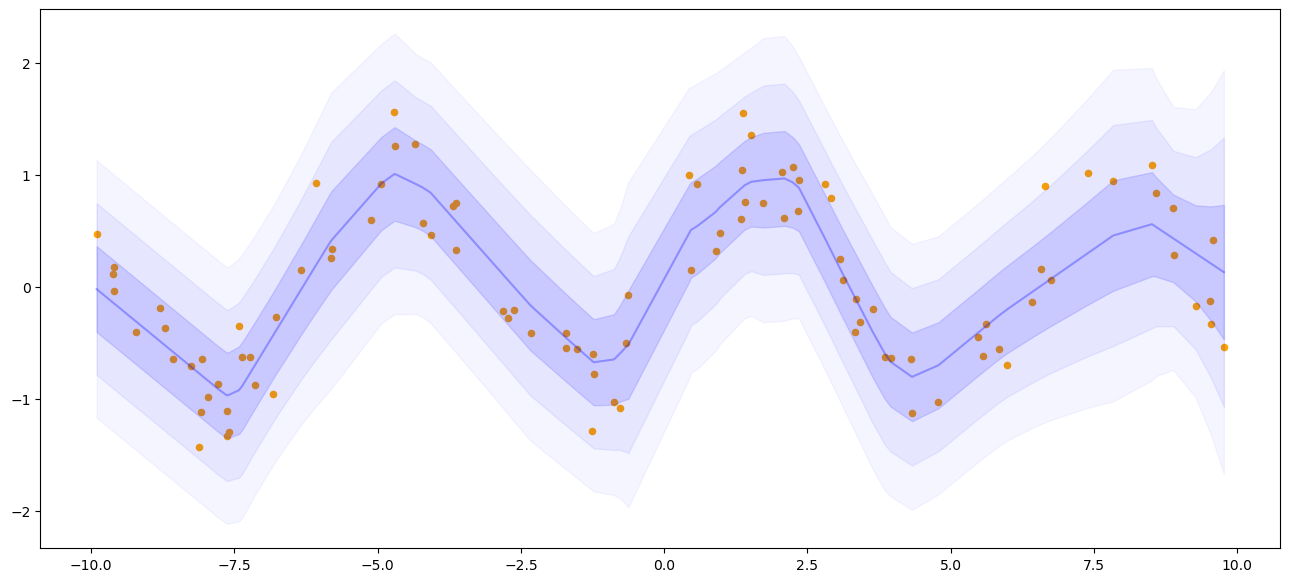

In [25]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_train, y_train, color="orange", s=20, alpha=1.0)
plt.plot(x_train[train_sort], means, color="blue", alpha=0.3)
for c in range(1, 4):
    plt.fill_between(x_train[train_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

In [26]:
test_sort = torch.argsort(x_test.squeeze())
preds = mcmc_bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)

# For homoskedastic aggregate True
means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

tensor([0.3756, 0.3850, 0.3850, 0.3729, 0.3725, 0.3850, 0.3850, 0.3850, 0.3763,
        0.3729, 0.3751, 0.3729, 0.3756, 0.3850, 0.3727, 0.3850, 0.3734, 0.3850,
        0.3729, 0.3729, 0.3850, 0.3729, 0.3850, 0.3850, 0.3734, 0.3850, 0.3726,
        0.3756, 0.3850, 0.3729, 0.3850, 0.3850, 0.3732, 0.3725, 0.3727, 0.3751,
        0.3850, 0.3850, 0.3762, 0.3850, 0.3850, 0.3734, 0.3850, 0.3850, 0.3850,
        0.3751, 0.3850, 0.3751, 0.3751, 0.3850, 0.3756, 0.3729, 0.3850, 0.3727,
        0.3727, 0.3756, 0.3850, 0.3756, 0.3732, 0.3759, 0.3850, 0.3850, 0.3850,
        0.3850, 0.3850, 0.3850, 0.3732, 0.3850, 0.3737, 0.3850, 0.3759, 0.3850,
        0.3756, 0.3756, 0.3850, 0.3850, 0.3850, 0.3751, 0.3850, 0.3850, 0.3756,
        0.3850, 0.3850, 0.3756, 0.3850, 0.3850, 0.3850, 0.3850, 0.3850, 0.3756,
        0.3734, 0.3850, 0.3850, 0.3751, 0.3725, 0.3763, 0.3763, 0.3734, 0.3756,
        0.3850, 0.3756, 0.3732, 0.3729, 0.3850, 0.3759, 0.3763, 0.3850, 0.3850,
        0.3850, 0.3850, 0.3850, 0.3729, 

tensor([0.3756, 0.3850, 0.3850, 0.3729, 0.3725, 0.3850, 0.3850, 0.3850, 0.3763,
        0.3729, 0.3751, 0.3729, 0.3756, 0.3850, 0.3727, 0.3850, 0.3734, 0.3850,
        0.3729, 0.3729, 0.3850, 0.3729, 0.3850, 0.3850, 0.3734, 0.3850, 0.3726,
        0.3756, 0.3850, 0.3729, 0.3850, 0.3850, 0.3732, 0.3725, 0.3727, 0.3751,
        0.3850, 0.3850, 0.3762, 0.3850, 0.3850, 0.3734, 0.3850, 0.3850, 0.3850,
        0.3751, 0.3850, 0.3751, 0.3751, 0.3850, 0.3756, 0.3729, 0.3850, 0.3727,
        0.3727, 0.3756, 0.3850, 0.3756, 0.3732, 0.3759, 0.3850, 0.3850, 0.3850,
        0.3850, 0.3850, 0.3850, 0.3732, 0.3850, 0.3737, 0.3850, 0.3759, 0.3850,
        0.3756, 0.3756, 0.3850, 0.3850, 0.3850, 0.3751, 0.3850, 0.3850, 0.3756,
        0.3850, 0.3850, 0.3756, 0.3850, 0.3850, 0.3850, 0.3850, 0.3850, 0.3756,
        0.3734, 0.3850, 0.3850, 0.3751, 0.3725, 0.3763, 0.3763, 0.3734, 0.3756,
        0.3850, 0.3756, 0.3732, 0.3729, 0.3850, 0.3759, 0.3763, 0.3850, 0.3850,
        0.3850, 0.3850, 0.3850, 0.3729, 

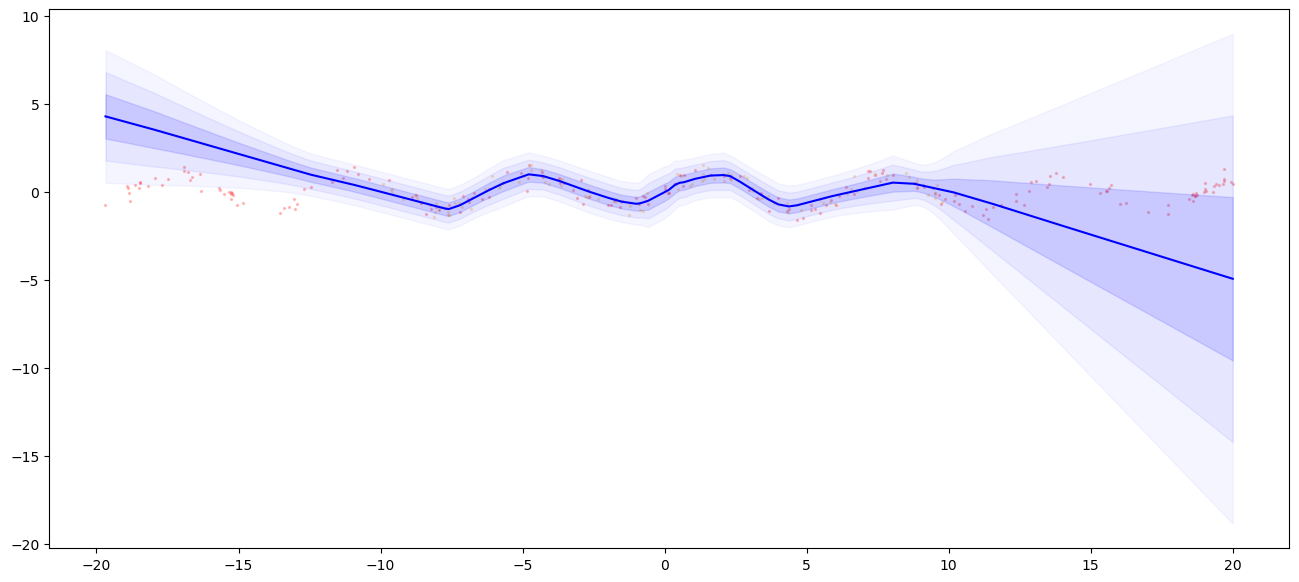

In [27]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
plt.plot(x_test[test_sort], means, color="blue")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

tensor([0.3850, 0.3756, 0.3756, 0.3751, 0.3756, 0.3729, 0.3850, 0.3850, 0.3850,
        0.3725, 0.3850, 0.3850, 0.3850, 0.3732, 0.3850, 0.3850, 0.3756, 0.3729,
        0.3850, 0.3756, 0.3850, 0.3850, 0.3725, 0.3850, 0.3751])
tensor([0.3850, 0.3756, 0.3756, 0.3751, 0.3756, 0.3729, 0.3850, 0.3850, 0.3850,
        0.3725, 0.3850, 0.3850, 0.3850, 0.3732, 0.3850, 0.3850, 0.3756, 0.3729,
        0.3850, 0.3756, 0.3850, 0.3850, 0.3725, 0.3850, 0.3751])


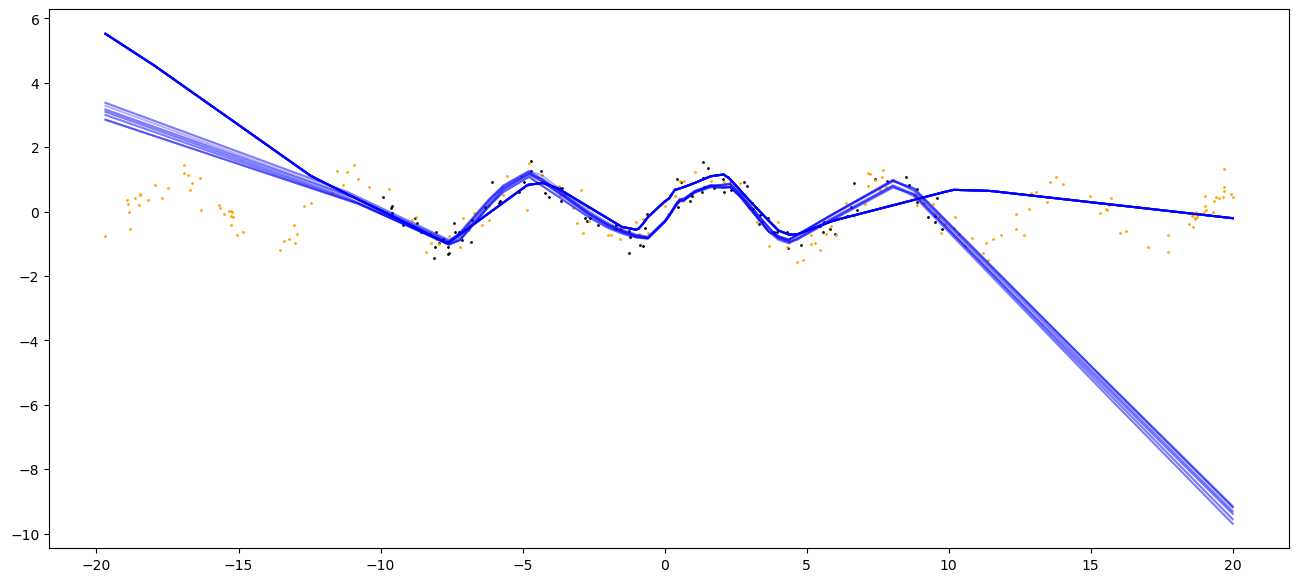

In [28]:


sampled_predictions = mcmc_bnn.predict(x_test[test_sort], num_predictions=25, aggregate=False)
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_train, y_train, color="black", s=1)
plt.scatter(x_test[test_sort], y_test[test_sort], color="orange", s=1)
for yhat in sampled_predictions:
    plt.plot(x_test[test_sort], yhat, color="blue", alpha=0.3)

In [29]:
bnn.get_error_metrics(x_train, y_train, num_predictions=100, reduction="mean")

NameError: name 'bnn' is not defined